```
This script can be used for any purpose without limitation subject to the
conditions at http://www.ccdc.cam.ac.uk/Community/Pages/Licences/v2.aspx

This permission notice and the following statement of attribution must be
included in all copies or substantial portions of this script.

2022-06-01: Made available by the Cambridge Crystallographic Data Centre.

```

# Substructure searching the CSD 

This notebook illustrates the use of the [Search API](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/search_api.html) by comparison with Conquest, with substructure searching of the CSD used as a specific example.

#### Some key references on the CSD and its contents

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4822653/
* https://pubs.acs.org/doi/10.1021/acs.chemrev.9b00155
* https://www.ccdc.cam.ac.uk/support-and-resources/support/case/?caseid=45f14529-2002-4558-887b-a502fbb2f874

In addition, this article here describes how CSD data can feed back into powder-diffraction studies:
https://onlinelibrary.wiley.com/doi/full/10.1107/S1600576717012596?sentby=iucr

#### Subsets of structures in the CSD

There are several subsets of the CSD available within the CSD Distribution.
You will find the available subsets in the `<CSD_2020 installation folder>\CSD_541\subsets`.

In addition a ‘Drug Subset’ of the CSD is available, which is described here:
https://www.sciencedirect.com/science/article/pii/S0022354918308104?via%3Dihub

Moreover, search filters (independent of search type) can be applied in ConQuest (the CCDC search application) and _via_ the CSD Python API, these cover things like maximum R-factor, the presence of disorder (in hydrogens and/or heavy atoms), whether structures are polymeric, are organic or organometallic _etc._
See [here](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/search_api.html#ccdc.search.Search.Settings) for details of how to implement this in the API (also demonstrated below).


In [9]:
from platform import platform
import sys

sys.path.append('../..')
from ccdc_notebook_utilities import run_hermes, create_logger

import os
from pathlib import Path
import logging
from datetime import date

import warnings

In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)  # Ignore current 'distutils Version classes are deprecated' warning
    
    import pandas as pd
    
    # import plotly.express as px
    import plotly.graph_objects as go

In [11]:
from IPython.display import HTML

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [12]:
import ccdc
from ccdc.diagram import DiagramGenerator
from ccdc.search import MoleculeSubstructure, SubstructureSearch, ConnserSubstructure, SMARTSSubstructure, TextNumericSearch, CombinedSearch

### Initialization

In [13]:
logger = create_logger()

[23-05-17 11:48:24 INFO   ] 
Platform:                     Windows-10-10.0.19045-SP0

Python exe:                   C:\Users\cole\Anaconda3\envs\latest_csd_python_api\python.exe
Python version:               3.9.16

CSD version:                  544
CSD directory:                C:/Users/cole/CCDC/ccdc-data/csd
API version:                  3.0.15

CSDHOME:                      C:/Users/cole/CCDC/ccdc-data/csd
CCDC_LICENSING_CONFIGURATION: Not set

[23-05-17 11:48:24 INFO   ] 
Platform:                     Windows-10-10.0.19045-SP0

Python exe:                   C:\Users\cole\Anaconda3\envs\latest_csd_python_api\python.exe
Python version:               3.9.16

CSD version:                  544
CSD directory:                C:/Users/cole/CCDC/ccdc-data/csd
API version:                  3.0.15

CSDHOME:                      C:/Users/cole/CCDC/ccdc-data/csd
CCDC_LICENSING_CONFIGURATION: Not set



Set up a CCDC Diagram Generator...

In [14]:
diagram_generator = DiagramGenerator()

diagram_generator.settings.return_type = 'SVG'
diagram_generator.settings.explicit_polar_hydrogens = False
diagram_generator.settings.shrink_symbols = False

Utility to help with display in JupyterLab...

In [15]:
show_df = lambda df: df.style.set_properties(**{'text-align': 'left'})

### Using ConQuest

Let us perform a Conquest search to use as a baseline.

Note that, in the instructions below, `> navigate to directory` means use the file chooser dialog to nativate to the directory this notebook is contained in (which will be the curent working directory, unless you have changed the directory above).

In [16]:
logger.info(f"Current working directory: {os.getcwd()}") 

[23-05-17 11:48:29 INFO   ] Current working directory: D:\builds\csd-python-api-scripts\notebooks\Discovery\01_CSD_Search
[23-05-17 11:48:29 INFO   ] Current working directory: D:\builds\csd-python-api-scripts\notebooks\Discovery\01_CSD_Search


1) Start ConQuest.


2) Load the supplied ConQuest query...

* `File > Read Queries... > navigate to directory > File name: aryl_sulphonamide.qry > Open`

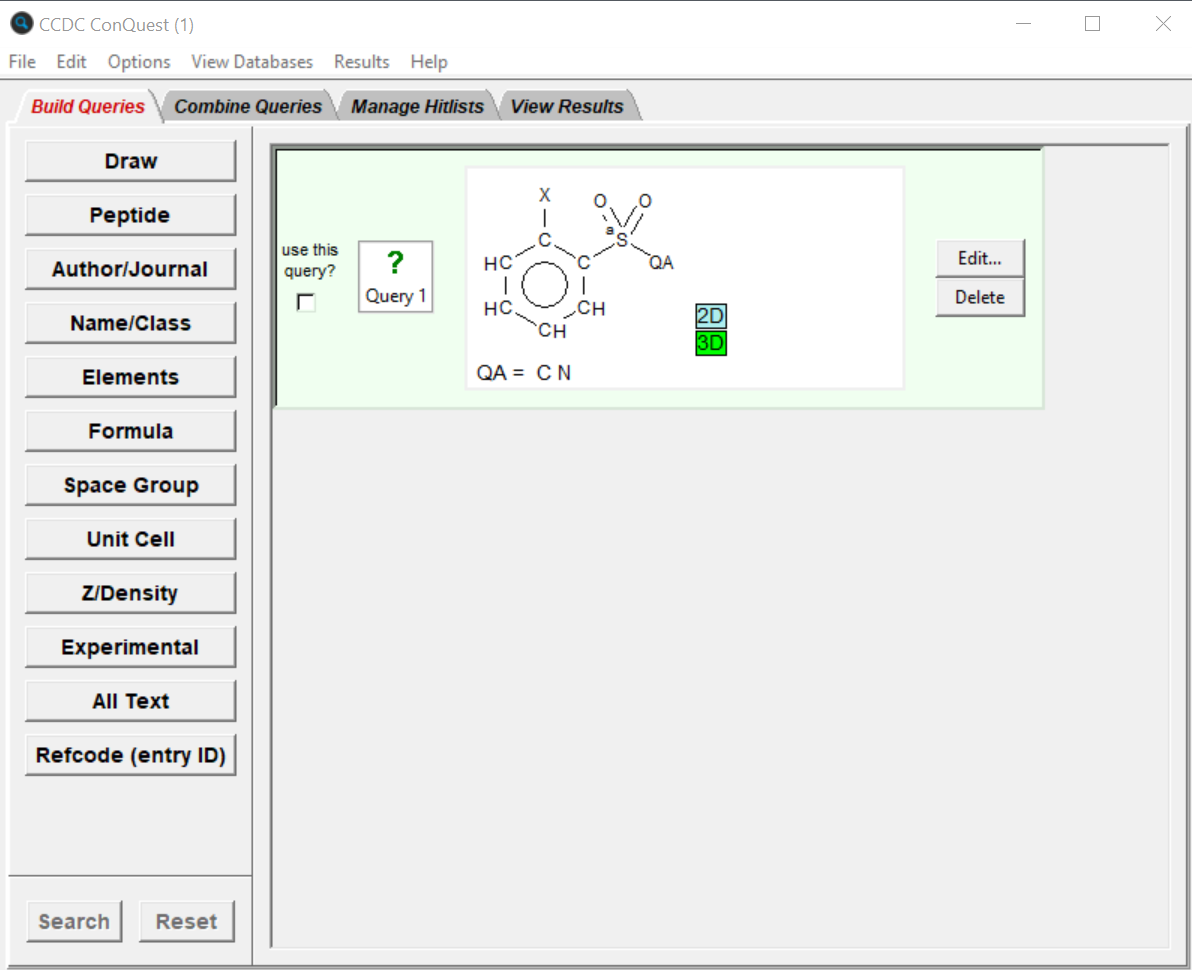

The substructure query used is shown below; to see this:

* Click the `Edit` button (to the right), then highlight both the `3D Parameters` (top right)

* The atomic number of _ortho_-substituent X (orange) is 3D Parameter `ANO1`, and the aryl-sulphone torsion angle (green) is `TOR1`.

* Click `Cancel` (bottom right to return to the main panel.

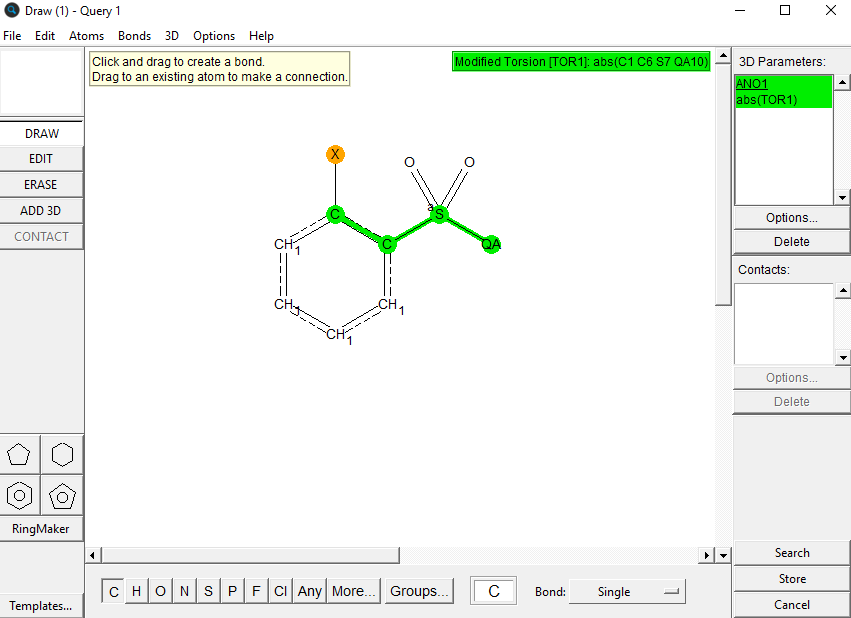


3) On the `Build Queries` tab, check the `use this query?` checkbox to the left of the image, then click the `Search` button (botton left of the panel).


5) The `Search Setup` dialog will appear; ensure all `Available Databases` are selected and the `Filters` shown below are used...

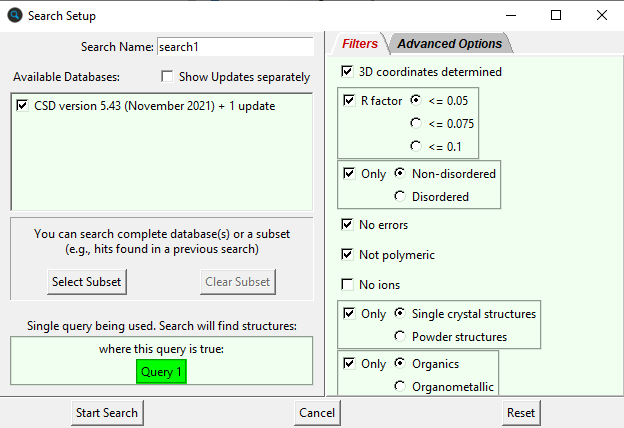


6) Click `Start Search` to run the search.


7) The hits may be inspected _via_ the `View Results` tab...

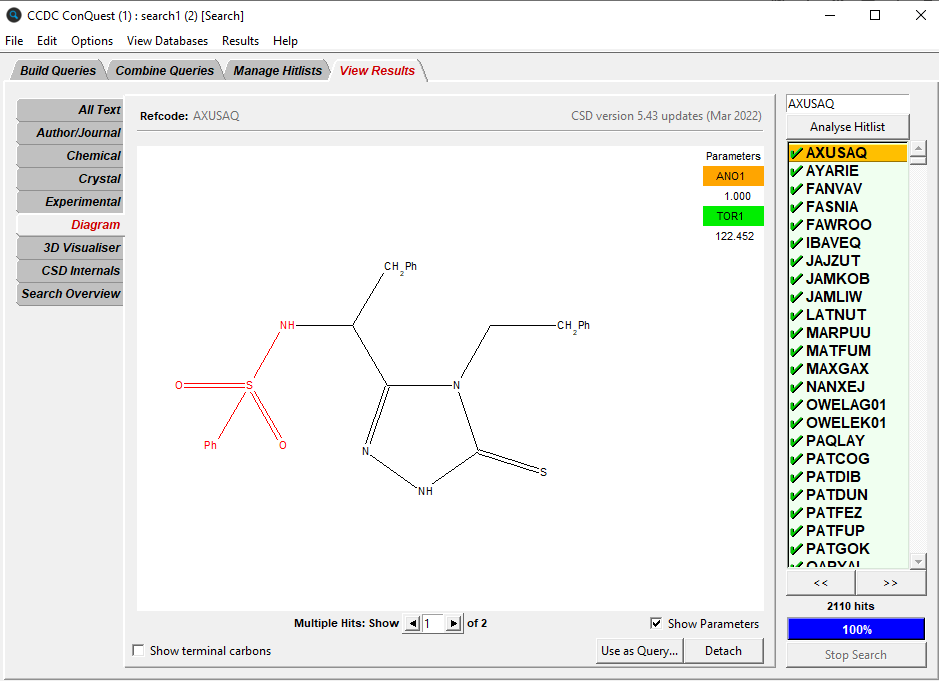

* Note that the numbers may be different depending on the version of the CSD used.


8) Set up the data export...

* `File > Export Parameters and Data > File type: Spreadsheet `

* Ensure `Include Defined Parameters` is checked so our measurements are exported

* Ensure `Other > Publication Year` is included as an example of 'non-measurement' data...

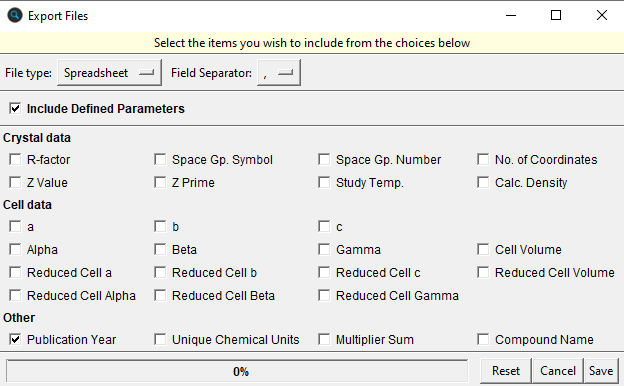


9) Click `Save` (bottom right) to open the file dialog...

* Navigate to the directory this notebook resides in (see above)

* Enter the name `aryl_sulphonamide.csv`

* Click `Save`

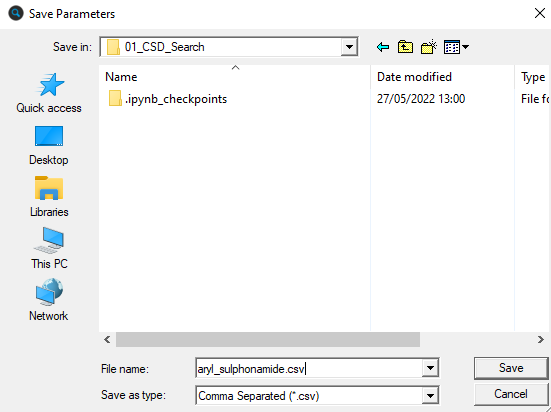

The spreadsheet file exported from ConQuest can then be loaded into a Pandas dataframe for inspection...

In [17]:
export_file = 'aryl_sulphonamide.csv'

In [18]:

if os.path.exists(export_file):
    conquest_df = pd.read_csv(export_file)  

    conquest_df.columns = [x.strip() for x in conquest_df.columns]  # Conquest adds extraneous spaces to some of the column names, so remove them

    conquest_df = (
        conquest_df
            .drop('Query', axis=1)  # Only one query here so the Query column is superfluous
            .sort_values(['Refcode', 'TOR1']).reset_index(drop=True)  # Sort on Refcode and TOR1 (helps with comparsions later)
            .assign(ANO1 = lambda df: df['ANO1'].astype(int))  # Fix type of ANO1; this is an atomic number, and thus integral, but gets converted to float
    )

    conquest_df['Refcode'].size, conquest_df['Refcode'].unique().size
else:
    conquest_df = None

The number of unique Refcodes is the same as shown in ConQuest, above. This is smaller than the total number of hits as the query matches some entries more than once. 

In [19]:
conquest_df

### Using ConnSer file exported from ConQuest in the API

Here, we search the CSD _via_ the API using the ConnSer query that was used in ConQuest above.

First, the query used in Conquest should be exported from Conquest in ConnSer (Quest) format...

* `Build Queries tab > Edit... > Draw > File > Export Quest Query > navigate to directory > File name: aryl_sulphonamide.con > Save as type: QUEST Query file (*.con) > Save`

In [20]:
query_file = 'aryl_sulphonamide.con'

In [21]:
query = ConnserSubstructure(query_file)

connser_searcher = SubstructureSearch()

sub_id = connser_searcher.add_substructure(query)

Set the search filters to correspond with those used in Conquest (we use a 'subroutine' to do this as we'll need to apply these settings again below)...

In [22]:
def set_search_filters(searcher):
    
    settings = searcher.settings
    
    settings.has_3d_coordinates = True
    settings.max_r_factor       = 5  # NB. Percentage not fraction; 0.05 in Conquest
    settings.no_disorder        = 'Non-hydrogen'
    settings.no_errors          = True
    settings.not_polymeric      = True
    settings.no_ions            = False
    settings.no_powder          = True
    settings.only_organic       = True

In [23]:
set_search_filters(connser_searcher)

One minor complication here is that Conquest and the API handle hits containing so-called 'siteless' hydrogen atoms slightly differently. These are cases where the submitter did not include some or all hydrogen atoms in the 3D connection table. While this is often not a problem, Conquest will miss the structure should one of these hydrogens be necessary to match a query. Now, the CSD adds these atoms to the connection table based on the 2D structure, and the API will find them without issue. This can lead to small discrepancies in the hit numbers in cases, such as the present one, when the query can match hydrogens (X can be any atom including hydrogen, and `APO1` records the atomic number of X). We thus include a post-filtering step to the API hits to remove these structures and thus mimic the behaviour of Conquest. It is important to note that the numbers of structures affected are small and tend to be from older submissions. In addition, the behaviour of the next generation of CSD search tools will reflect that of the API. Thus, while the post-processing step is included here to emphasise that the API is fully compatible with Conquest, in practice this step could be removed without issue.

Note also that, as a CSD structure can contain multiple examples of a particular substructure, such as that defining a torsion angle, the number of measurements will typically be significantly larger than the number of distinct structures. As an example, in the present case, the _ortho_-substituent X may be a hyrodgen atom. As the query specifies that other  _ortho_-substituent _must_ be a hydrogen, in this case the substructure will match twice and two torsion angle measurements will be generated. 

In [24]:
%%time

connser_hits = connser_searcher.search()

connser_hits = [hit for hit in connser_hits if all(atom.coordinates is not None for atom in hit.match_atoms())]  # filter out hits with siteless atoms in matching substructure

len(connser_hits), len(set(x.identifier for x in connser_hits))  # Number of measurements vs. number of distinct structures

CPU times: total: 1min 17s
Wall time: 1min 10s


(4953, 2196)

Here we make a dataframe for the hits from the ConnSer search, adding in the publication year to illustrate extacting Entry attributes for hits.

In [25]:
measurements = list(connser_hits[0].measurements.keys())   # For convenience, we pull the list of measurement names from first hit

connser_df = (
    pd.DataFrame(
        data   =[[hit.identifier, *hit.measurements.values(), hit.entry.publication.year] for hit in connser_hits],   
        columns=[ 'Refcode',      *measurements             , 'Publication Year'] 
    )
    .sort_values(['Refcode', 'TOR1']).reset_index(drop=True)  # Sort on Refcode and TOR1 (helps with comparsions)
    .assign(ANO1 = lambda df: df['ANO1'].astype(int))  # Fix type of ANO1; this is an atomic number, and thus integral, but gets converted to float
) 

connser_df['Refcode'].size, connser_df['Refcode'].unique().size

(4953, 2196)

The hit structures are the same as from Conquest...

In [26]:
assert (conquest_df['Refcode'] == connser_df['Refcode']).all()

TypeError: 'NoneType' object is not subscriptable

The dataframes are identical, apart, apparently, from the TOR1 columns...

In [ ]:
(conquest_df == connser_df).all()

Inspection shows that Conquest has rounded `TOR1` to three decimal places, whereas the API doesn't do this...

In [ ]:
conquest_df['TOR1'].head(3).tolist()

connser_df['TOR1'].head(3).tolist()

Taking this into account, we can show that the `TOR1` columns are actually equal and thus that the Conquest and API datasets are in fact the same...

In [ ]:
assert all([(abs(x - y) < 0.001) for x, y in zip(conquest_df['TOR1'], connser_df['TOR1'])])

### Combined Searching

The [CombinedSearch API](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/combined_search.html) can be used to combine different types of search, such as Substructure search and Text/Numeric search. Here we illustrate the latter using a publication-year constraint...

In [ ]:
start_year = 2015

In [ ]:
tn_searcher = TextNumericSearch()

tn_searcher.add_citation(year=[start_year, date.today().year])  # 2015 to present

set_search_filters(tn_searcher)  # Set the search filters

We combine the two searches using the `&` operator...

In [ ]:
combined_searcher = CombinedSearch(connser_searcher & tn_searcher)

Search the CSD using this combined query...

In [ ]:
%%time

combined_hits = combined_searcher.search()

combined_hits = [hit for hit in combined_hits if all(atom.coordinates is not None for atom in hit.match_atoms())]  # filter out hits with siteless atoms in matching substructure

len(combined_hits), len(set(x.identifier for x in combined_hits))   # Number of measurements vs. number of distinct structures

Make a dataframe, as before...

In [ ]:
measurements = list(combined_hits[0].measurements.keys())   # We simply the pull list of measurement names from first hit

combined_df = (
    pd.DataFrame(
        data   =[[hit.identifier, *hit.measurements.values(), hit.entry.publication.year] for hit in combined_hits],   # Note that we store the hit object in the dataframe for convenience
        columns=[ 'Refcode',      *measurements             , 'Publication Year'] 
    )
    .sort_values(['Refcode', 'TOR1']).reset_index(drop=True)  # Sort on Refcode and TOR1 (helps with comparsions)
    .assign(ANO1 = lambda df: df['ANO1'].astype(int))  # Fix type of ANO1; this is an atomic number, and thus integral, but gets converted to float
) 

combined_df['Refcode'].size, combined_df['Refcode'].unique().size

In [ ]:
# combined_df

An equivalent search was run in Conquest, and the number of distinct structures returned is the same as obtained from the API...

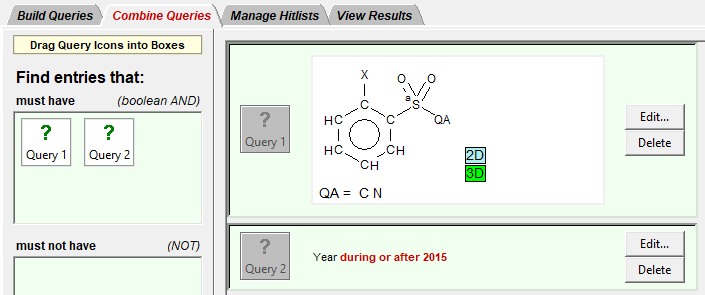

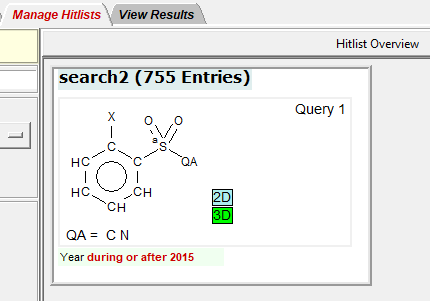

Check Publication Years...

In [ ]:
combined_df['Publication Year'].value_counts().to_frame().sort_index().head()

Comparison with the original search results shows the Publication Year filter has worked as expected...

In [ ]:
connser_df['Publication Year'].value_counts().to_frame().sort_index().head()

### SMARTS searching

The CSD Python API may also be used to search the CSD using SMARTS queries.

The CSD Python API implementation of SMARTS is currently a subset of the full SMARTS functionality: details of the discrepancies are available [here](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/smarts.html). Note that the SMARTS implementation is being extended, and most of the limitations will be removed soon.

For the present case, the important difference is that constraints of combined with the comma (_i.e._ the OR operator) are not supported. To get the same result as the ConnSer search above we much use multiple queries and OR them together explicity using a CombinedSearch.

Note that the measurements are specified for substructures using (zero-based) query atom indices.

SMARTS patterns corresponding to the ConnSer query...

In [ ]:
pattern = '*-c1c([S!r]([#6,#7])(=O)(=O))[cH][cH][cH][cH]1'

In [ ]:
query = SMARTSSubstructure(pattern)

smarts_searcher = SubstructureSearch()

sub_id = smarts_searcher.add_substructure(query)  # Record 'substructure id' for later reference

smarts_searcher.add_atom_property_measurement('ANO1', (sub_id, 0), which='AtomicNumber')

smarts_searcher.add_torsion_angle_measurement('TOR1_RAW', *[(sub_id, n) for n in [1, 2, 3, 4]])  # Use substructure id and query atom indices

smarts_searcher.add_unary_transform_measurement('TOR1', 'ABS', 'TOR1_RAW')  # Absolute torsion angle

set_search_filters(smarts_searcher)  # Note that the search filters must be set on the basic searchers, not on e.g. the combined searcher

Search the CSD using the SMARTS queries...

In [ ]:
%%time

smarts_hits = smarts_searcher.search()

smarts_hits = [hit for hit in smarts_hits if all(atom.coordinates is not None for atom in hit.match_atoms())]  # filter out hits with siteless atoms in matching substructure

len(smarts_hits), len(set(x.identifier for x in smarts_hits))

Here we make a DataFrame for the hits from the SMARTS search, much as before. Note that the mechanism the API uses for defining the torsion angle means there is an extra column containing the 'raw' torsion angle measurement, which we discard.

In [ ]:
measurements = list(smarts_hits[0].measurements.keys())  # For convenience, we the pull list of measurement names from first hit

smarts_df = (
    pd.DataFrame(
        data   =[[hit.identifier, *hit.measurements.values(), hit.entry.publication.year] for hit in smarts_hits],   
        columns=[ 'Refcode',      *measurements             , 'Publication Year'        ] 
    )
    .sort_values(['Refcode', 'TOR1']).reset_index(drop=True)  # Sort on Refcode and TOR1 (helps with comparsions)
    .assign(ANO1 = lambda df: df['ANO1'].astype(int))  # Fix type of ANO1; this is an atomic number, and thus integral, but gets converted to float
    .drop('TOR1_RAW', axis=1)  # Ignore the raw torsion angle measurement and keep only the absolute value
) 

smarts_df['Refcode'].size, smarts_df['Refcode'].unique().size

In [ ]:
smarts_df.head()

The hit structures are the same as for the ConnSer search and, in fact, the dataframes are identical...

In [ ]:
assert (connser_df['Refcode'].unique() == smarts_df['Refcode'].unique()).all()

assert (smarts_df == connser_df).all().all()

### Further Combined Searching

The CombinedSearch API can also be used recursively, _e.g._ to combine the SMARTS combined substructure searcher with the Text/Numeric searcher...

In [ ]:
combined_searcher_2 = CombinedSearch(smarts_searcher & tn_searcher)

This SMARTS-based combined search give the same hits as the ConnSer-based version above...

In [ ]:
%%time

combined_hits_2 = combined_searcher.search()

combined_hits_2 = [x for x in combined_hits_2 if all(y.coordinates is not None for y in x.match_atoms())]  # filter out hits with siteless atoms in matching substructure

len(combined_hits_2), len(set(x.identifier for x in combined_hits_2))   # Number of measurements vs. number of distinct structures

In [ ]:
assert len(combined_hits_2) == len(combined_hits)

### Molfiles

Molfile queries can also be used to search the CSD. However, atom lists are not currently supported, so the ConnSer query used above could not be represented in a single molfile query. While multiple molfile queries could be combined in a similar way to the SMARTS patterns shown above, this will not be illustrated here.

### Depicting hits

Here, we add depictions to dataframe, highlighting the torsion measurement defined by the query. Note that we take only a portion of the hits, as the depiction generation isn't very fast.

Note that we are taking the hit objects from the original hitlist here. The hit objects could also have been cached in the dataframe, which would facilitate actions such as depicting a random sample of the hits instead of just the top _N_ as is done here.

In [ ]:
N = 50  # Number of hits to take

In [ ]:
# Utility function to generate a depiction highlighting TOR1...

depiction = lambda x: diagram_generator.image(x.molecule, highlight_atoms=x.measurement_objects('TOR1'))

In [ ]:
depiction_df = (
    smarts_df
        .iloc[:N]
        .assign(depiction = [depiction(hit) for hit in connser_hits[:N]]) 
)

In [ ]:
show_df(depiction_df.head(3))  # We need to use the show_dataframe utility so the depictions are rendered properly

Note that, unlike the `SubstructureHit` object used in the SMARTS and ConnSer searchers, the `CombinedHit` object returned by the combined searchers doesn't currently have a `measurement_objects` attribute, so, unfortunately, we can't get at the atoms defining the measurements as we can in the simple substucture searchers version. It does have a `measurements` attribute, however. 

In [ ]:
assert not hasattr(combined_hits[0], 'measurement_objects')

combined_hits[0].measurements

### Intermolecular interactions

The Search API can also be used to search for and tabulate data on intermolecular interactions in the CSD, just as Conquest can, and an example is available in the [Desciptive Docs](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/substructure_searching.html#substructure-searching-with-geometric-constraints). However, this will not be illustrated here. Instead, the notebook [Protein_Ligand_Searching](../Protein_Ligand/Protein_Ligand_Searching.ipynb) shows how the same Search API can also be used to mine the PDB for data on intermolecular interactions.

### Plotting histograms

Here, we use the plotting package [Plotly](https://plotly.com/python/) to generate histograms of torsion angles, in much the same way as might be done in Vista or Mercury.

Comparing the torsion-angle histograms for the _ortho_-unsubstituted structures _vs._ the _ortho_-substituted structures clearly shows the difference in the distributions.

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)  # Ignore current 'distutils Version classes are deprecated' warning
    
    (go.Figure(layout_title_text="Plot of TOR1 for Unsubstituted and ortho-substituted aryl sulphonamides")
        .add_trace(go.Histogram(x=smarts_df.query("ANO1 == 1")['TOR1'], name='Unsubstituted'))
        .add_trace(go.Histogram(x=smarts_df.query("ANO1 >  1")['TOR1'], name='ortho-substituted')) 
        .update_layout(barmode='overlay')
        .update_traces(opacity=0.75) 
        .update_xaxes(title_text="TOR1")
        .update_yaxes(title_text="Number of observations")    
        .show()
    )